In [1]:
'''
00_RandomWalk.py : Replication of figure 9.1
Cem Karaoguz, 2020
MIT License
'''

import numpy as np
import pylab as pl

from IRL.environments.ToyExamples import RandomWalk
from IRL.agents.MonteCarloApproximation import GradientMonteCarloPrediction
from IRL.utils.FeatureTransformations import stateAggregation
from IRL.utils.ApproximationFunctions import linearTransform, dLinearTransform

if __name__=="__main__":  
  nEpisodes = 10000
  
  # Environment
  nStatesOneSide = 250
  specialRewards = {nStatesOneSide*2:1.0, 0:-1.0}
  groundTruth = np.zeros(nStatesOneSide*2+1)
  groundTruth[nStatesOneSide:] = np.arange(nStatesOneSide+1)/nStatesOneSide
  groundTruth[0:nStatesOneSide] = np.arange(nStatesOneSide,0,-1)/(-nStatesOneSide)
  groundTruth = groundTruth[1:nStatesOneSide*2]
  nStates = nStatesOneSide*2+1
  
  # Agents
  alpha_MC = 2e-5
  gamma_MC = 1.0
  nParams_MC = 10
  approximationFunctionArgs_MC = {'af':linearTransform, 'afd':dLinearTransform, 
    'ftf':stateAggregation, 'nStates':nStates, 'nParams':nParams_MC}  
  
  env = RandomWalk(nStatesOneSide, specialRewards=specialRewards)
  agent_MC = GradientMonteCarloPrediction(env.nStates, nParams_MC, alpha_MC, gamma_MC, approximationFunctionArgs=approximationFunctionArgs_MC)
  
  for e in range(nEpisodes):
    
    if e%100==0:
      print("Episode : ", e)
      
    experiences = [{}]
    done = False
    state = env.reset()

    while not done:     
      experiences[-1]['state'] = state
      experiences[-1]['done'] = done

      new_state, reward, done = env.step()
      
      experiences[-1]['action'] = env.lastAction

      xp = {}
      xp['reward'] = reward
      xp['state'] = new_state
      xp['done'] = done
      experiences.append(xp)
      
      state = new_state
      
    agent_MC.update(experiences)
  
  estimatedValues_MC = [agent_MC.getValue(state) for state in range(env.nStates-1)]

  pl.figure()
  pl.plot(groundTruth, 'k', label="Real values")
  pl.plot(estimatedValues_MC, label=agent_MC.getName())
  pl.xlabel("State")
  pl.ylabel("Value")
  pl.legend()
  
  mu = agent_MC.getMu()
  pl.figure()
  pl.bar(range(len(mu)), mu)
  pl.xlabel("State")
  pl.ylabel("Distribution")
  pl.show()


Episode :  0
Episode :  100
Episode :  200
Episode :  300
Episode :  400
Episode :  500
Episode :  600
Episode :  700
Episode :  800
Episode :  900
Episode :  1000
Episode :  1100
Episode :  1200
Episode :  1300


KeyboardInterrupt: 

idxExperiment: 0
Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 1200
Episode: 1300
Episode: 1400
Episode: 1500
Episode: 1600
Episode: 1700
Episode: 1800
Episode: 1900
Episode: 2000
Episode: 2100
Episode: 2200
Episode: 2300
Episode: 2400
Episode: 2500
Episode: 2600
Episode: 2700
Episode: 2800
Episode: 2900
Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 1200
Episode: 1300
Episode: 1400
Episode: 1500
Episode: 1600
Episode: 1700
Episode: 1800
Episode: 1900
Episode: 2000
Episode: 2100
Episode: 2200
Episode: 2300
Episode: 2400
Episode: 2500
Episode: 2600
Episode: 2700
Episode: 2800
Episode: 2900
Episode: 0
Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 12

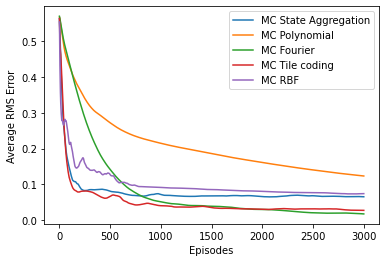

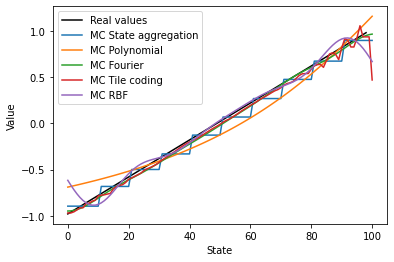

In [2]:
'''
02_RandomWalk_features.py : Demonstration of various feature transformation methods 
presented in the book with linear function approximation using gradient MC on a simple
Random Walk task and replication of figures 9.5 and 9.6.
Cem Karaoguz, 2020
MIT License
'''

import numpy as np
import pylab as pl

from IRL.environments.ToyExamples import RandomWalk
from IRL.agents.MonteCarloApproximation import GradientMonteCarloPrediction
from IRL.utils.FeatureTransformations import stateAggregation, polynomial, fourier, tileCoding, radialBasisFunction
from IRL.utils.ApproximationFunctions import linearTransform, dLinearTransform

def runExperiment(nEpisodes, env, agent, groundTruth):
  rmse = np.zeros(nEpisodes)
  for e in range(nEpisodes):
    
    if e%100==0:
      print("Episode:", e)
      
    experiences = [{}]
    done = False
    state = env.reset()

    while not done:     
      experiences[-1]['state'] = state
      experiences[-1]['done'] = done

      new_state, reward, done = env.step()
      
      xp = {}
      xp['reward'] = reward
      xp['state'] = new_state
      xp['done'] = done
      experiences.append(xp)

      state = new_state
    
    agent.update(experiences)
    
    estimatedValues = [agent.getValue(state) for state in range(env.nStates)]
    rmse[e] = np.sqrt(np.mean( (groundTruth - estimatedValues[1:agent.nStates-1])**2 ) )

  return np.array(rmse)
  
if __name__=="__main__":  
  nExperiments = 1
  nEpisodes = 5000
  
  # Environment
  nStatesOneSide = 50
  specialRewards = {nStatesOneSide*2:1.0, 0:-1.0}
  groundTruth = np.zeros(nStatesOneSide*2+1)
  groundTruth[nStatesOneSide:] = np.arange(nStatesOneSide+1)/nStatesOneSide
  groundTruth[0:nStatesOneSide] = np.arange(nStatesOneSide,0,-1)/(-nStatesOneSide)
  groundTruth = groundTruth[1:nStatesOneSide*2]
  nStates = nStatesOneSide*2+1
  
  # Agents
  alpha_MC_stag = 2e-3
  gamma_MC_stag = 1.0
  nParams_MC_stag = 10
  approximationFunctionArgs_MC_stag = {'af':linearTransform, 'afd':dLinearTransform, 
    'ftf':stateAggregation, 'nStates':nStates, 'nParams':nParams_MC_stag}  
  
  alpha_MC_pol = 1e-4
  gamma_MC_pol = 1.0
  nParams_MC_pol = 10
  c_MC_pol = np.resize(range(nParams_MC_pol), [nParams_MC_pol,1])
  approximationFunctionArgs_MC_pol = {'af':linearTransform, 'afd':dLinearTransform, 
    'ftf':polynomial, 'nStates':nStates, 'nParams':nParams_MC_pol, 'c':c_MC_pol, 'stateNormFactor':1.0/nStates}

  alpha_MC_fou = 5e-5
  gamma_MC_fou = 1.0
  nParams_MC_fou = 10
  approximationFunctionArgs_MC_fou = {'af':linearTransform, 'afd':dLinearTransform, 
    'ftf':fourier, 'nParams':nParams_MC_fou, 'stateNormFactor':1.0/nStates}

  alpha_MC_tc = 1e-3
  gamma_MC_tc = 1.0
  minStates = [0]
  maxStates = [nStates]
  nTilings = 5
  tilingOffsets = np.array([np.linspace(-4, 4*(nTilings-1)-4,num=nTilings)]).T # (idxTiling, dimState)
  tilingSize = np.array([np.ones(nTilings, dtype=int)*20]).T # (idxTiling, dimState)
  nParams_MC_tc = int(np.sum(tilingSize))
  approximationFunctionArgs_MC_tc = {'af':linearTransform, 'afd':dLinearTransform, 
    'ftf':tileCoding, 'minStates':minStates, 'maxStates':maxStates, 
    'nTilings':nTilings, 'tilingOffsets':tilingOffsets, 'tilingSize':tilingSize}
         
  alpha_MC_rbf = 1e-3
  gamma_MC_rbf = 1.0
  nParams_MC_rbf = 10
  mu_MC_rbf = np.linspace(0, nStates,num=nParams_MC_rbf+2)[1:-1]
  sigma_MC_rbf = np.ones(nParams_MC_rbf)*10
  approximationFunctionArgs_MC_rbf = {'af':linearTransform, 'afd':dLinearTransform, 
    'ftf':radialBasisFunction, 'mu':mu_MC_rbf, 'sigma':sigma_MC_rbf}
  
  env = RandomWalk(nStatesOneSide, specialRewards=specialRewards) 
  
  avg_rmse_MC_stag = np.zeros(nEpisodes)
  avg_vals_MC_stag = np.zeros(env.nStates)
  avg_rmse_MC_pol = np.zeros(nEpisodes)
  avg_vals_MC_pol = np.zeros(env.nStates)
  avg_rmse_MC_fou = np.zeros(nEpisodes)
  avg_vals_MC_fou = np.zeros(env.nStates) 
  avg_rmse_MC_tc = np.zeros(nEpisodes)
  avg_vals_MC_tc = np.zeros(env.nStates)
  avg_rmse_MC_rbf = np.zeros(nEpisodes)
  avg_vals_MC_rbf = np.zeros(env.nStates) 
  for idx_experiment in range(nExperiments):
    
    print("idxExperiment:", idx_experiment)
    
    # State aggregation
    agent_MC_stag = GradientMonteCarloPrediction(env.nStates, nParams_MC_stag, alpha_MC_stag, gamma_MC_stag, 
      approximationFunctionArgs=approximationFunctionArgs_MC_stag)
    
    rmse_MC_stag = runExperiment(nEpisodes, env, agent_MC_stag, groundTruth)
    estimatedValues_MC_stag = np.array([agent_MC_stag.getValue(state) for state in range(env.nStates)])
    avg_vals_MC_stag = avg_vals_MC_stag + (1.0/(idx_experiment+1))*(estimatedValues_MC_stag - avg_vals_MC_stag)
    avg_rmse_MC_stag = avg_rmse_MC_stag + (1.0/(idx_experiment+1))*(rmse_MC_stag - avg_rmse_MC_stag)
    
    # Polynomial features
    agent_MC_pol =  GradientMonteCarloPrediction(env.nStates, nParams_MC_pol, alpha_MC_pol, gamma_MC_pol, 
      approximationFunctionArgs=approximationFunctionArgs_MC_pol)
    
    rmse_MC_pol = runExperiment(nEpisodes, env, agent_MC_pol, groundTruth)
    estimatedValues_MC_pol = np.array([agent_MC_pol.getValue(state) for state in range(env.nStates)])
    avg_vals_MC_pol = avg_vals_MC_pol + (1.0/(idx_experiment+1))*(estimatedValues_MC_pol - avg_vals_MC_pol)
    avg_rmse_MC_pol = avg_rmse_MC_pol + (1.0/(idx_experiment+1))*(rmse_MC_pol - avg_rmse_MC_pol)
    
    # Fourier feature transform
    agent_MC_fou =  GradientMonteCarloPrediction(env.nStates, nParams_MC_fou, alpha_MC_fou, gamma_MC_fou, 
      approximationFunctionArgs=approximationFunctionArgs_MC_fou)
    
    rmse_MC_fou = runExperiment(nEpisodes, env, agent_MC_fou, groundTruth)
    estimatedValues_MC_fou = np.array([agent_MC_fou.getValue(state) for state in range(env.nStates)])
    avg_vals_MC_fou = avg_vals_MC_fou + (1.0/(idx_experiment+1))*(estimatedValues_MC_fou - avg_vals_MC_fou)
    avg_rmse_MC_fou = avg_rmse_MC_fou + (1.0/(idx_experiment+1))*(rmse_MC_fou - avg_rmse_MC_fou)
        
    # Tile coding
    agent_MC_tc = GradientMonteCarloPrediction(env.nStates, nParams_MC_tc, alpha_MC_tc, gamma_MC_tc, 
      approximationFunctionArgs=approximationFunctionArgs_MC_tc)
    
    rmse_MC_tc = runExperiment(nEpisodes, env, agent_MC_tc, groundTruth)
    estimatedValues_MC_tc = np.array([agent_MC_tc.getValue(state) for state in range(env.nStates)])
    avg_vals_MC_tc = avg_vals_MC_tc + (1.0/(idx_experiment+1))*(estimatedValues_MC_tc - avg_vals_MC_tc)
    avg_rmse_MC_tc = avg_rmse_MC_tc + (1.0/(idx_experiment+1))*(rmse_MC_tc - avg_rmse_MC_tc)

    agent_MC_rbf = GradientMonteCarloPrediction(env.nStates, nParams_MC_rbf, alpha_MC_rbf, gamma_MC_rbf, 
      approximationFunctionArgs=approximationFunctionArgs_MC_rbf)
    
    rmse_MC_rbf = runExperiment(nEpisodes, env, agent_MC_rbf, groundTruth)
    estimatedValues_MC_rbf = np.array([agent_MC_rbf.getValue(state) for state in range(env.nStates)])
    avg_vals_MC_rbf = avg_vals_MC_rbf + (1.0/(idx_experiment+1))*(estimatedValues_MC_rbf - avg_vals_MC_rbf)
    avg_rmse_MC_rbf = avg_rmse_MC_rbf + (1.0/(idx_experiment+1))*(rmse_MC_rbf - avg_rmse_MC_rbf)
    
  fig, ax = pl.subplots()
  ax.plot(avg_rmse_MC_stag, label="MC State Aggregation")
  ax.plot(avg_rmse_MC_pol, label="MC Polynomial")
  ax.plot(avg_rmse_MC_fou, label="MC Fourier")
  ax.plot(avg_rmse_MC_tc, label="MC Tile coding")
  ax.plot(avg_rmse_MC_rbf, label="MC RBF")
  ax.set_xlabel("Episodes")
  ax.set_ylabel("Average RMS Error")
  pl.legend()
  
  pl.figure()
  pl.plot(groundTruth, 'k', label="Real values")
  pl.plot(avg_vals_MC_stag, label="MC State aggregation")
  pl.plot(avg_vals_MC_pol, label="MC Polynomial")
  pl.plot(avg_vals_MC_fou, label="MC Fourier")

  pl.xlabel("State")
  pl.ylabel("Value")
  pl.legend()
  pl.show()

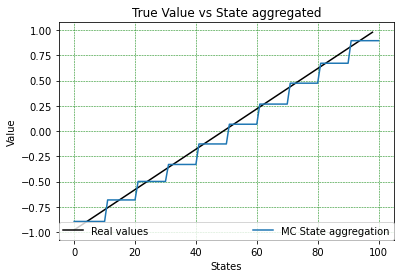

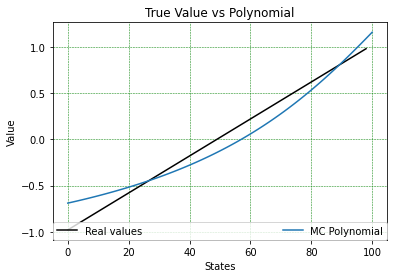

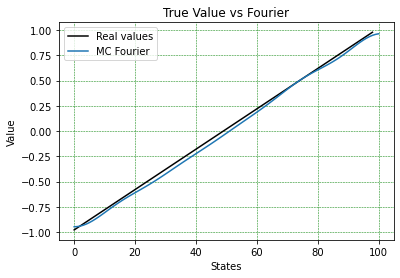

In [5]:
pl.figure()
pl.plot(groundTruth, 'k', label="Real values")
pl.plot(avg_vals_MC_stag, label="MC State aggregation")
pl.ylabel('Value')
pl.xlabel('States')
pl.title("True Value vs State aggregated")
pl.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
pl.grid(color = 'green', linestyle = '--', linewidth = 0.5)

pl.figure()
pl.plot(groundTruth, 'k', label="Real values")
pl.plot(avg_vals_MC_pol, label="MC Polynomial")
pl.ylabel('Value')
pl.xlabel('States')
pl.title("True Value vs Polynomial")
pl.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
pl.grid(color = 'green', linestyle = '--', linewidth = 0.5)

pl.figure()
pl.plot(groundTruth, 'k', label="Real values")
pl.plot(avg_vals_MC_fou, label="MC Fourier")
pl.ylabel('Value')
pl.xlabel('States')
pl.title("True Value vs Fourier")
pl.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
pl.grid(color = 'green', linestyle = '--', linewidth = 0.5)

pl.legend()
pl.show()

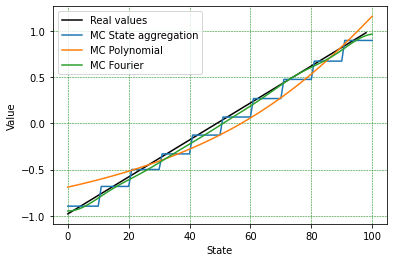

In [7]:
pl.figure()
pl.plot(groundTruth, 'k', label="Real values")
pl.plot(avg_vals_MC_stag, label="MC State aggregation")
pl.plot(avg_vals_MC_pol, label="MC Polynomial")
pl.plot(avg_vals_MC_fou, label="MC Fourier")
pl.grid(color = 'green', linestyle = '--', linewidth = 0.5)
pl.xlabel("State")
pl.ylabel("Value")
pl.legend()
pl.show()